# Large Language Model exercise

In [1]:
import hdbscan
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import tqdm
import umap
import wordcloud
from scipy.cluster.hierarchy import linkage
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## **Basic overview**

**Large Language Models (LLMs)** are a class of artificial intelligence (AI) models designed to process and generate human-like text. These models have been trained on vast amounts of textual data and use deep learning techniques to understand patterns, context, and relationships in language.

LLMs have become a focal point of technological innovation, driving advances in natural language processing (NLP). They have demonstrated the ability to assist with tasks such as text completion, translation, summarization, and question-answering. Their versatility has led to widespread adoption across industries, from business and finance to healthcare and scientific research.

At a fundamental level, LLMs work by predicting the next word (or token) in a sequence, given a preceding context. Specifically, an LLM learns, by being trained on vast amounts of text data, to complete sentences with the most likely token. For example:

"The capital of the USA is ____ ." , choosing from (New York | Washington D.C. | Hamster | inquisitive)

This predictive capability enables them to generate coherent and contextually relevant text.

LLMs are the current paradigm in NLP modeling and are the result of a long line of research:

1. Early Rule-Based and Statistical Models (before the 2010s) – Before deep learning, NLP relied on rule-based approaches and statistical methods like n-grams, which analyzed word sequences but lacked deep contextual understanding.
2. Neural Networks and Recurrent Models – The introduction of neural networks improved NLP capabilities, but traditional recurrent neural networks (RNNs) struggled with long-range dependencies in text.
3. The **Transformer** Revolution (2017) – The breakthrough came with the introduction of the Transformer architecture by Vaswani et al. in the paper "Attention Is All You Need." This model replaced RNNs and LSTMs with a more efficient structure that processes words in parallel using self-attention mechanisms.
4. The Rise of LLMs (2018–Present) – With transformers as key element, models such as BERT (2018), GPT-2 (2019), T5 (2019), GPT-3 (2020), and GPT-4 (2023) have pushed the boundaries in model size and performance.

Transformers are a specific type of neural network architecture that has proven to be particularly adept at processing text. They operate on the principle of self-attention, which allows them to assign different importance levels to words in a sentence. Unlike traditional models that process text sequentially, transformers can consider all words in a string in parallel, capturing contextual relationships more effectively.

At the heart of the transformer sits the self-attention mechanism, which enables the model to relate individual words to the context surrounding them. The transformer architecture combines self-attention modules with feed-forward layers, residual connections and layer normalizations:


Modern LLMs consist typically of mutliple transformer blocks, allowing them to learn different aspects of textual understanding (e.g. syntactic understanding, semantic understanding, etc.).

Key components of a transformer-based model include:

- Tokenization – Splitting text into smaller units (tokens), which can be words, subwords, or characters.
- Embeddings – Converting tokens into numerical vectors that capture semantic meaning.
- Attention Mechanism – Assigning weights to different words based on their relevance to the current token being processed.
- Feedforward Layers – Processing and refining learned representations.
- Training with Large Datasets – Models are pre-trained on massive text corpora and fine-tuned for specific tasks.

LLMs can be broadly **classified** based on their architecture and functionality:

1. **Decoder-Based (Generative) Models**

    These models specialize in text generation and are trained to predict the next word in a sequence. They are typically used for open-ended tasks like content creation, dialogue generation, and creative writing.
    
    Examples:
    
    - GPT Series (GPT-2, GPT-3, GPT-4, LLaMA, Claude, PaLM)
    - Gemini (Google DeepMind)
    - Mistral, Grok, Claude,...


2. **Encoder-Based (Understanding) Models**

    Encoder-based models are designed primarily for understanding text rather than generating it. They primarily produce textual embeddings (see below) for tasks such as text classification, regression analysis, sentiment analysis, and named entity recognition.
    
    Examples:
    
    - BERT (Bidirectional Encoder Representations from Transformers)
    - RoBERTa (A robustly optimized BERT model)
    - ModernBERT (An optimized version of BERT)
    - Domain-specific models, e.g. FinBERT and EconBERT

In this exercise we will **focus on Encoder-Based models**, as these lend themselves more directly towards empirical analysis.

## **Textual embeddings**

**Embeddings are numerical representations of words**, phrases, or entire documents that capture their meaning in a structured mathematical space. They serve as the foundation of modern NLP models, allowing machines to understand and manipulate human language in a way that preserves semantic relationships.

In the context of LLMs, embeddings play a crucial role in encoding linguistic information, enabling models to process and generate text with a deep contextual understanding. Instead of treating words as discrete symbols, embeddings transform them into dense vectors of real numbers, allowing LLMs to analyze patterns and relationships more effectively.

Traditional NLP models used techniques like one-hot encoding, where each word was represented as a binary vector with a single 1 at the word’s index in a vocabulary list. However, this method suffers from two major limitations:

- Scalability issues – Large vocabularies lead to extremely high-dimensional vectors, making computations inefficient.
- Lack of semantic relationships – One-hot encoding treats all words as independent, failing to capture similarities between words (e.g., "economy" and "market" would be entirely separate entities).

Embeddings address these problems by mapping words to lower-dimensional spaces, where words with similar meanings are positioned closer together. This improves the model’s ability to recognize patterns, understand context, and generalize across different tasks.

Static embeddings are fixed word representations that do not change based on context. Some classic examples include:

- Word2Vec – A neural network-based model that learns word relationships based on their co-occurrence in text.
- GloVe (Global Vectors for Word Representation) – Uses statistical techniques to generate embeddings from word co-occurrence matrices.

Such static embeddings struggle with contextual information. For example, the meaning of "bank" drastically changes depending on its surrounding context (e.g. financial institution or land alongside a body of water).

Unlike static embeddings, **contextual embeddings** based on the attention mechanism found in LLMs change depending on how a word is used in a sentence. This allows models to distinguish between different meanings of the same word.

We illustrate the work embedding concept with a small example. Consider the following phrases on different topics:

1. Inflation
2. Labour
3. Stocks
4. Commodities



In [2]:
inflation_sents = [
    "Inflation is the rate at which the general level of prices for goods and services is rising, consequently eroding purchasing power.",
    "Central banks, such as the Federal Reserve in the United States, often aim to control inflation through monetary policy, adjusting interest rates to either slow down or stimulate the economy.",
    "Inflation is typically measured using the Consumer Price Index (CPI), which tracks the cost of a basket of commonly purchased goods and services over time.",
    "While moderate inflation is a sign of a growing economy, hyperinflation can lead to a rapid and uncontrollable rise in prices, severely disrupting an economy.",
    "Deflation, the opposite of inflation, occurs when prices decline, which can lead to decreased production and increased unemployment if persistent.",
    "Cost-push inflation occurs when prices rise due to increases in the cost of production and raw materials, while demand-pull inflation happens when demand for goods and services exceeds supply.",
    "Governments and central banks often set an inflation target to balance economic growth and maintain the currency's value.",
    "Unexpected inflation can benefit debtors, as they end up paying back their debts with money that is worth less, while it can harm creditors for the same reason.",
    "Inflation expectations can be self-fulfilling; if people expect prices to rise, they may spend more now, thereby actually pushing prices up.",
    "Wage inflation occurs when workers' pay rises at a rapid rate, which can contribute to broader inflationary pressures in the economy.",
    "Asset inflation is a rise in the prices of assets like real estate, stocks, or gold, and it doesn't always coincide with general inflation.",
    "Inflation can erode savings over time, as the future value of money is reduced, making it a critical consideration for long-term financial planning.",
    "The Quantity Theory of Money suggests that inflation is caused by an increase in the money supply relative to the availability of goods and services.",
    "During periods of high inflation, consumers may experience a decline in their standard of living as their income buys fewer goods and services.",
    "Stagflation is a challenging economic condition characterized by slow economic growth, high unemployment, and rising inflation.",
    "Governments may resort to inflationary financing, or printing more money, to cover budget deficits, but this can lead to hyperinflation if done excessively.",
    "Supply shocks, like sudden increases in oil prices, can cause temporary inflationary spikes that central banks typically look through unless they become persistent.",
    "Core inflation is a measure that excludes volatile food and energy prices to provide a clearer picture of the underlying inflation trend.",
    "Indexed bonds, such as Treasury Inflation-Protected Securities (TIPS), are designed to protect investors from the erosive effect of inflation.",
    "Understanding inflation is crucial for investors, as it influences various asset classes differently, affecting portfolio returns over time.",
]

labour_sents = [
    "Labor markets are the arenas in which employers seek to hire work and workers seek to find jobs.",
    "Unemployment rates are a key indicator of labor market health, reflecting the percentage of people actively looking for work but unable to find employment.",
    "Labor demand is influenced by economic conditions, technological advancements, and industry growth or decline.",
    "Minimum wage laws aim to protect workers from exploitation, ensuring they receive a basic standard of living for their labor.",
    "Labor unions play a critical role in negotiating wages, benefits, and working conditions on behalf of their members.",
    "The gig economy, characterized by short-term contracts and freelance work, has significantly changed traditional labor market dynamics.",
    "Skills mismatch, where workers' qualifications do not align with available jobs, is a common challenge in labor markets.",
    "Labor mobility refers to the ease with which workers can move between jobs, industries, or geographic areas to find employment.",
    "Automation and artificial intelligence are reshaping labor markets, creating new opportunities while making certain skills obsolete.",
    "Economic globalization has expanded labor markets, allowing employers to source talent from around the world and workers to find jobs in other countries.",
    "Discrimination based on gender, race, age, or other factors can lead to unequal opportunities and outcomes in the labor market.",
    "Seasonal employment patterns, such as increased retail hiring during holiday seasons, are a characteristic feature of many labor markets.",
    "Labor market policies, including unemployment insurance and job training programs, aim to support workers and encourage efficient functioning of the market.",
    "Youth unemployment is a persistent issue in many countries, reflecting the difficulties young people face in entering the labor market.",
    "The informal sector, consisting of unregulated and often untaxed jobs, is a significant part of the labor market in many developing countries.",
    "Labor productivity, or output per worker, is a crucial factor in determining wages and overall economic performance.",
    "Occupational safety and health regulations are essential for protecting workers from hazards and ensuring fair labor practices.",
    "Labor market flexibility, referring to how easily employers can adjust their workforce and workers can change jobs, varies significantly between countries.",
    "Remote work and telecommuting have become increasingly prevalent, offering new flexibility for workers and employers alike.",
    "Labor market trends and forecasts help governments, businesses, and individuals make informed decisions about education, career paths, and economic policies.",
]
stock_sents = [
    "Stock market trading involves buying and selling shares of publicly traded companies to capitalize on price fluctuations.",
    "Traders use fundamental analysis to evaluate a company's financial health and intrinsic value, guiding their buy or sell decisions.",
    "Technical analysis is another tool traders use, studying statistical trends from trading activity to predict price movements.",
    "Market volatility refers to the frequency and magnitude of price movements in the stock market, impacting trading strategies.",
    "Bull markets are characterized by rising stock prices and optimism, while bear markets reflect declining prices and pessimism.",
    "Day traders buy and sell stocks within the same trading day, capitalizing on short-term price movements.",
    "Stop-loss orders are a risk management tool traders use to limit potential losses by automatically selling at a predetermined price.",
    "Liquidity in the stock market refers to the ease with which stocks can be bought or sold without significantly affecting their price.",
    "Diversification is a strategy traders use to spread their investments across various stocks or sectors to mitigate risk.",
    "Margin trading involves borrowing money to buy stocks, potentially amplifying gains and losses.",
    "High-frequency trading utilizes algorithms to execute trades at extremely high speeds, capitalizing on minute price discrepancies.",
    "Initial Public Offerings (IPOs) mark the first time a company's shares are available for public purchase on the stock market.",
    "Dividends are a portion of a company's profits paid to shareholders, and they can influence trading decisions.",
    "A stock market index, like the S&P 500 or Dow Jones Industrial Average, tracks the performance of a selected group of stocks.",
    "Short selling involves borrowing shares to sell them with the hope of buying them back at a lower price, profiting from a price decline.",
    "Market sentiment is the overall attitude of investors toward a particular stock or the stock market in general, influencing price movements.",
    "Insider trading is illegal and involves trading based on non-public, material information about a company.",
    "Options trading allows investors to buy or sell stocks at a specific price within a set period, offering different strategies like calls and puts.",
    "Earnings reports and other significant news can cause substantial price swings, and traders often plan around these events.",
    "Portfolio rebalancing is the process of realigning the weightings of a portfolio's assets to maintain a desired risk level and investment strategy.",
]

commodities_sents = [
    "Commodities are raw materials or agricultural products that can be bought and sold, with prices set by market demand.",
    "The most well-known commodities include oil, gold, and wheat, each playing a critical role in the global economy.",
    "Commodities markets are influenced by factors like supply and demand, geopolitical tensions, and natural disasters.",
    "Investing in commodities can be a way to hedge against inflation, as their prices often increase when the cost of living rises.",
    "The energy sector, including oil and natural gas, is a significant part of the commodities market and affects everyday life.",
    "Precious metals like gold and silver are viewed as safe-haven assets during times of economic uncertainty.",
    "Agricultural commodities, such as corn, soybeans, and coffee, are essential for food production and consumption.",
    "Commodity trading began centuries ago and was crucial for the exchange of essential goods between regions and nations.",
    "Futures contracts are commonly used to trade commodities, allowing buyers and sellers to agree on a price for future delivery.",
    "Commodity prices can be highly volatile, presenting both risks and opportunities for traders and investors.",
    "Technological advancements in farming and extraction have significantly impacted the supply and thus the prices of various commodities.",
    "Developing countries often rely heavily on commodities for their economic growth and foreign exchange earnings.",
    "The Organization of the Petroleum Exporting Countries (OPEC) plays a significant role in determining oil prices globally.",
    "Environmental concerns and regulations can significantly impact commodity markets, especially those related to energy and mining.",
    "The rise of renewable energy sources is gradually changing the dynamics of the commodities market, particularly for fossil fuels.",
    "Market speculators who buy and sell commodities for profit can influence prices beyond the fundamental factors of supply and demand.",
    "Commodity exchanges around the world, like the Chicago Mercantile Exchange, facilitate the trading of commodity futures and options.",
    "Storage and transportation costs are crucial in the commodities market, significantly affecting the total cost and supply chain.",
    "Weather patterns and seasonal cycles can have a substantial impact on agricultural commodities, affecting both yield and price.",
    "Investors often use commodities as part of a diversified portfolio to reduce risk and potentially improve returns over time.",
]

print(len(inflation_sents))

20


We embed each of these sentences using the MPNet-v2 model, an encoder-type LLM:

In [3]:
model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")  # MPNet model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
inflation_embeds = model.encode(inflation_sents)
labour_embeds = model.encode(labour_sents)
stock_embeds = model.encode(stock_sents)
comm_embeds = model.encode(commodities_sents)

all_embeds = np.vstack(
    [inflation_embeds, labour_embeds, stock_embeds, comm_embeds]
)  # Combined embeddings
labels = (
    (["Inflation"] * 20)
    + (["Labour"] * 20)
    + (["Stock Market"] * 20)
    + (["Commodities"] * 20)
)

all_embeds = pd.DataFrame(all_embeds)

In [5]:
all_embeds

0         1         2         3         4         5         6    \
0  -0.051773 -0.042313  0.007178  0.016063 -0.020772  0.057553 -0.080787   
1  -0.009201 -0.055850 -0.030680  0.009187  0.003350  0.070065 -0.055324   
2  -0.049912  0.005014 -0.018819  0.008902 -0.050279  0.068381 -0.053148   
3  -0.018551  0.007209 -0.006562 -0.005858  0.037527  0.069085 -0.062008   
4  -0.059045 -0.037125 -0.033133  0.012100 -0.029711 -0.007060 -0.050462   
..       ...       ...       ...       ...       ...       ...       ...   
75  0.027624  0.033570 -0.008905 -0.008316 -0.009817 -0.036310  0.072861   
76  0.000721 -0.013051 -0.009972 -0.011094  0.006451  0.006397  0.067087   
77  0.008420  0.038916 -0.018333  0.033720  0.045086 -0.005410  0.056485   
78 -0.023043  0.051874 -0.021254  0.047718  0.015836 -0.004703  0.036204   
79  0.002498  0.002377 -0.033568  0.004762  0.030555  0.008428  0.063366   

         7         8         9    ...       758       759       760       761  \
0   0.030492 -0.046634  0.028297  ... -0.065244  0.035658  0.060607  0.033031   
1  -0.029330  0.001227  0.030740  ... -0.047866  0.036634  0.032275  0.007393   
2  -0.013095 -0.028035  0.022751  ... -0.028791 -0.002927  0.037589  0.004633   
3  -0.014596 -0.005752  0.016045  ... -0.050290  0.021909  0.016454  0.030392   
4   0.024605 -0.041317  0.069300  ... -0.012595 -0.047910  0.049718  0.004286   
..       ...       ...       ...  ...       ...       ...       ...       ...   
75 -0.019339 -0.040485  0.038434  ...  0.016123  0.074091 -0.033773  0.028544   
76  0.024945  0.013574 -0.002464  ...  0.041875  0.034000  0.038933  0.023688   
77 -0.010367 -0.042781 -0.014918  ... -0.006646  0.071117 -0.014608  0.019509   
78 -0.060431  0.006997  0.001449  ...  0.030645  0.034707  0.000162 -0.057546   
79  0.038797 -0.017446  0.006599  ... -0.011181  0.020636 -0.017117  0.045588   

         762       763       764       765       766       767  
0   0.008882 -0.072062  0.031283  0.012008  0.012454  0.034193  
1   0.012431 -0.020422  0.015410  0.033690  0.016094  0.054763  
2   0.029845 -0.078273 -0.020015  0.008970 -0.023636  0.041048  
3   0.001717 -0.069797  0.027565 -0.015924  0.013816  0.039150  
4   0.012696 -0.077021  0.022877 -0.013776  0.046427  0.010481  
..       ...       ...       ...       ...       ...       ...  
75 -0.012656 -0.075477 -0.048828  0.030945 -0.023214 -0.023090  
76  0.017643  0.001221 -0.044087  0.009535 -0.027172 -0.034132  
77  0.003940 -0.021157 -0.022039 -0.000003 -0.084133 -0.009301  
78  0.043259  0.006432 -0.025941  0.010045 -0.026295 -0.023057  
79  0.020724 -0.053672 -0.032011  0.020431 -0.024889 -0.038544  

[80 rows x 768 columns]

Each embedding is a vector with 768 components.  Each row in the above DataFrame corresponds to a sentence. We want to verify that embeddings on the same topic (e.g. inflation) are close to each other while those from different topics are further apart. To this end, we apply a dimension reduction algorithm, UMAP, which is particularly well suited for reducing textual embeddings.

In [6]:
umap_model = umap.UMAP(n_components=2, random_state=42, metric="cosine")
umap_results = umap_model.fit_transform(all_embeds)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


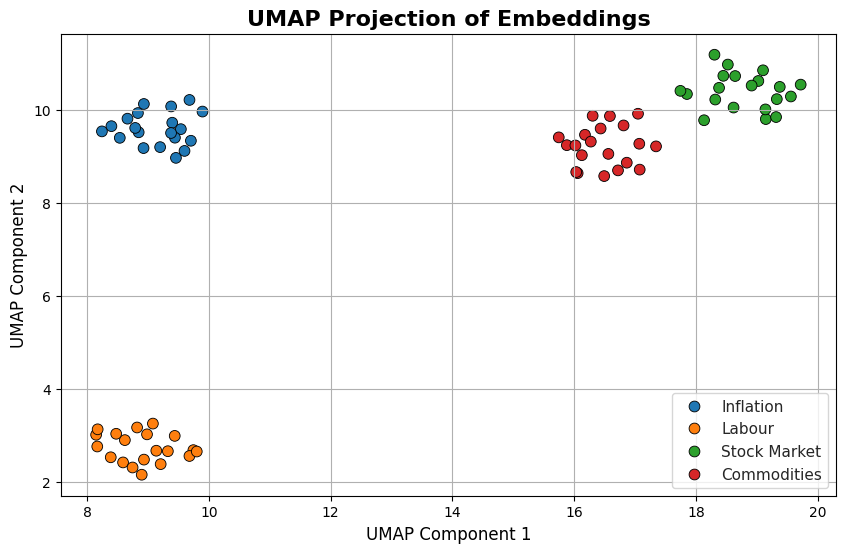

In [7]:
# Create figure and axis for plotting
fig, ax = plt.subplots(figsize=(10, 6))  # Adjusted for better readability

# Set Seaborn style
sns.set(style="whitegrid")

# Create scatter plot with UMAP results
scatter = sns.scatterplot(
    x=umap_results[:, 0],
    y=umap_results[:, 1],
    hue=labels,
    palette="tab10",
    s=60,
    edgecolor="black",
    ax=ax,
)

# Set plot title and labels
ax.set_title("UMAP Projection of Embeddings", fontsize=16, fontweight="bold")
ax.set_xlabel("UMAP Component 1", fontsize=12)
ax.set_ylabel("UMAP Component 2", fontsize=12)
ax.grid(True)

# Adjust legend handling
if len(set(labels)) > 10:  # Hide legend if too many unique labels
    ax.legend_.remove()

## Questions

1.  Are the topics are clearly separated and can be identified using a clustering algorithm?

Answer:

Yes, the topics are clearly separated. In the UMAP projection, each topic forms a distinct, dense cluster with minimal overlap. This spatial separation suggests that a clustering algorithm (e.g. K-means or DBSCAN) could effectively identify and group these topics based on their embeddings alone.


2.  What does the spatial arrangement of the clusters suggest about relationships between the topics, and can we interpret these distances as meaningful in a semantic context?

Answer:

The spatial distances between clusters in the UMAP projection reflect semantic similarity. For instance, if the "Stock Market" and "Commodities" clusters are closer together than, say, "Inflation" and "Labour," it suggests that their sentence embeddings share more contextual or topical overlap. This could align with real-world relationships—for example, stock prices and commodity prices are both influenced by global markets, investor behavior, and economic policy, which may not apply as directly to labor market trends.

3.  Have we managed to translate semantic differences into mathematical differences using LLMs?

Answer:

Yes, we have. The LLM-generated embeddings effectively encode semantic content, allowing similar topics to cluster together in the vector space while separating distinct ones. The clear grouping seen in the UMAP plot confirms that the model captures underlying semantic distinctions and expresses them as measurable vector differences. This demonstrates the model’s capability to abstract meaning and structure from text, validating the effectiveness of contextual embeddings produced by encoder-based LLMs like MPNet.

## **Application: Economic Topic Modeling**

We apply the above technique to analyzing a news dataset. We want to get an idea about the most common topics covered, and how they evolve over time. Let's first load in the news dataset.

In [8]:
articles = pd.read_pickle(
    "https://raw.githubusercontent.com/chansen776/MBA-ML-Course-Materials/main/Data/article_sample.pkl"
)

In [9]:
articles

headline  \
article_id                                                                               
dn_f8bdab034f25c52fd1b4bcb613595960  U.N. Appeals For More Help For Chinese Flood V...   
dn_eda9a93b0ef50b1b69ccda5768160d95  Microphone Maker Knowles Faces Legal Challenge...   
dn_8f1f54c084163e0236ccb02897402793  DOJ: 14 People Charged In Large-Scale Florida ...   
dn_3c9e96385ceacaac43236038218e7249  N Korea Says Woman Allegedly Abducted By Japan...   
dn_e2cdd9e4346648abb6e51830948712fb  Official: US' Russia Envoy Choice For No 3 Spo...   
...                                                                                ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  SandRidge, Arena Settle 6 Of 9 Lawsuits Linked...   
dn_32794cd2fb89e5e488afbed511eb5f46  IRS Union Concerned About IRS Nominee, Debt Co...   
dn_cc433ecbd320f55c658834ae6b4742d0  DJ US Sen Irked By Reports Japan To Up Refrige...   
dn_0701d085a3dda7bd2593463d0444ebb7  Egypt Welcomes Prospect of Warmer U.S.-Russia ...   
dn_77715f48eb6379cd26e2f006d3705bcf  Ruling In Sun-Microsoft Java Suit May Come As ...   

                                                                                  body  \
article_id                                                                               
dn_f8bdab034f25c52fd1b4bcb613595960  Chinese communities devastated by deadly flood...   
dn_eda9a93b0ef50b1b69ccda5768160d95  By Eva Dou Knowles, a supplier of microphones ...   
dn_8f1f54c084163e0236ccb02897402793  Fourteen people were charged with conspiracy a...   
dn_3c9e96385ceacaac43236038218e7249  North Korea said a woman who claimed she was t...   
dn_e2cdd9e4346648abb6e51830948712fb  A senior official said Friday the U.S. ambassa...   
...                                                                                ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  SandRidge Energy Inc. (SD)  and Arena Resource...   
dn_32794cd2fb89e5e488afbed511eb5f46  The union representing Internal Revenue Servic...   
dn_cc433ecbd320f55c658834ae6b4742d0  Senate Finance Committee Chairman Charles Gras...   
dn_0701d085a3dda7bd2593463d0444ebb7  as Donald Trump prepares to become president n...   
dn_77715f48eb6379cd26e2f006d3705bcf  A first-round decision in the courtroom battle...   

                                    display_date  
article_id                                        
dn_f8bdab034f25c52fd1b4bcb613595960   1999-02-10  
dn_eda9a93b0ef50b1b69ccda5768160d95   2014-04-03  
dn_8f1f54c084163e0236ccb02897402793   2011-02-25  
dn_3c9e96385ceacaac43236038218e7249   2005-04-20  
dn_e2cdd9e4346648abb6e51830948712fb   2008-01-18  
...                                          ...  
dn_e3ad31a908b3bfc86a766e20610c6d45   2010-05-28  
dn_32794cd2fb89e5e488afbed511eb5f46   2008-03-07  
dn_cc433ecbd320f55c658834ae6b4742d0   2003-07-30  
dn_0701d085a3dda7bd2593463d0444ebb7   2016-12-08  
dn_77715f48eb6379cd26e2f006d3705bcf   1998-11-06  

[10000 rows x 3 columns]

The dataset consists of article headlines, article bodies, the article publication date, as well as a unique identifier. We look at some headlines and article texts:

In [10]:
articles["headline"][:3].values

array(['U.N. Appeals For More Help For Chinese Flood Victims',
       'Microphone Maker Knowles Faces Legal Challenge In China -- WSJ Blog',
       'DOJ: 14 People Charged In Large-Scale Florida Mortgage Fraud'],
      dtype=object)

In [11]:
articles["body"][:3].values

array(['Chinese communities devastated by deadly floods last summer may suffer outbreaks of disease and remain dependent on handouts if they do not get urgent help in rebuilding water systems, roads and farms, U.N. officials said Wednesday. U.N. agencies working to rebuild areas destroyed by the floods, which killed 4,150 people, appealed for $41.6 million in new relief funds for long-term reconstruction projects. Of that amount, a large share - $18.5 million - would go to restoring farms by clearing flood-damaged land, repairing irrigation works and providing fertilizer and seeds, the agencies said at a news conference. Without such help, millions of people may remain dependent on food aid, U.N. officials said. Kirsten Leitner, U.N. resident coordinator in China, said the relief efforts were focused on helping the neediest of the 180 million people affected by the floods, the worst in 44 years. "There are lots of people who have been left to struggle on their own," Leitner said. "Some

## Questions

4. What kinds of topics do the articles cover?  

Answer:
The articles span a variety of economic and geopolitical topics. These include:
- Natural disasters and humanitarian relief (e.g., Chinese flood victims and aid efforts)
- Corporate legal disputes (e.g., Knowles vs. competitors over patent infringement)
- Financial crimes and fraud (e.g., mortgage fraud investigations)
- Geopolitical conflicts (e.g., North Korean abduction issues)
- Government policies and international relations (e.g., U.S. ambassador appointments)

5. Is it feasible to manually classify all articles in this dataset?  

Answer:
No, it is not feasible to manually classify all 10,000 articles. Manual classification would be extremely time-consuming and prone to inconsistency due to the subjective nature of labeling and human error. Automated techniques like topic modeling, clustering, or classification using NLP and LLMs are more efficient and scalable for this dataset.

6. According to the above printouts, how many articles are currently read into data?

Answer:
The printout from the DataFrame indicates that 10,000 articles have been read into the dataset, as shown at the bottom of the table: 10000 rows × 3 columns.

### Embedding articles

If the number of articles is too large for us to classify them manually, we might instead want to **apply LLMs to automatically analyze this corpus at scale**.

We start our analysis by embedding the corpus using a LLM. We use again the MPNet model from above and embedd the combined article headlines and bodies. Note: the following cell may take long to run. You can just load in the file with the embeddings that we pre-computed for you.

**Warning:  The upcoming encoding can take several minutes**

In [12]:
combined_articles = articles["headline"] + ". " + articles["body"]
article_embeds = model.encode(combined_articles)  # Takes <= 5 min

/usr/local/lib/python3.11/dist-packages/sentence_transformers/SentenceTransformer.py:649: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentences_sorted = [sentences[idx] for idx in length_sorted_idx]


In [13]:
article_embeds = pd.DataFrame(article_embeds, index=articles.index)
article_embeds

0         1         2         3    \
article_id                                                                    
dn_f8bdab034f25c52fd1b4bcb613595960  0.025585  0.077653 -0.017860  0.022713   
dn_eda9a93b0ef50b1b69ccda5768160d95  0.036542  0.035058 -0.001356 -0.015604   
dn_8f1f54c084163e0236ccb02897402793 -0.030126  0.050997 -0.022283 -0.017762   
dn_3c9e96385ceacaac43236038218e7249  0.058896  0.067468  0.012853  0.022404   
dn_e2cdd9e4346648abb6e51830948712fb  0.024671  0.074106  0.036619 -0.002388   
...                                       ...       ...       ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  0.049976  0.057801  0.000719 -0.013740   
dn_32794cd2fb89e5e488afbed511eb5f46 -0.003679  0.083939  0.016668  0.015157   
dn_cc433ecbd320f55c658834ae6b4742d0  0.004990  0.107120  0.018690 -0.007759   
dn_0701d085a3dda7bd2593463d0444ebb7  0.017494  0.054746  0.004004 -0.000624   
dn_77715f48eb6379cd26e2f006d3705bcf  0.053828  0.046404 -0.001525 -0.004479   

                                          4         5         6         7    \
article_id                                                                    
dn_f8bdab034f25c52fd1b4bcb613595960  0.021599  0.004027 -0.006668 -0.040633   
dn_eda9a93b0ef50b1b69ccda5768160d95  0.036801 -0.021105  0.092949 -0.031594   
dn_8f1f54c084163e0236ccb02897402793 -0.036609  0.044718  0.021646 -0.025963   
dn_3c9e96385ceacaac43236038218e7249  0.027337  0.003620 -0.004430  0.007881   
dn_e2cdd9e4346648abb6e51830948712fb -0.000773 -0.007263  0.033656  0.039157   
...                                       ...       ...       ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  0.020919 -0.014755  0.026651  0.015032   
dn_32794cd2fb89e5e488afbed511eb5f46 -0.019730  0.009055 -0.009329  0.009409   
dn_cc433ecbd320f55c658834ae6b4742d0 -0.003775  0.015660  0.013732  0.065719   
dn_0701d085a3dda7bd2593463d0444ebb7  0.001648 -0.008956  0.020136 -0.002169   
dn_77715f48eb6379cd26e2f006d3705bcf -0.057013 -0.019676 -0.023082  0.021891   

                                          8         9    ...       758  \
article_id                                               ...             
dn_f8bdab034f25c52fd1b4bcb613595960  0.036102 -0.012395  ... -0.042499   
dn_eda9a93b0ef50b1b69ccda5768160d95 -0.023589  0.002575  ... -0.050069   
dn_8f1f54c084163e0236ccb02897402793  0.033707  0.036943  ... -0.066199   
dn_3c9e96385ceacaac43236038218e7249  0.015964  0.024480  ...  0.015978   
dn_e2cdd9e4346648abb6e51830948712fb  0.070620 -0.023193  ... -0.001389   
...                                       ...       ...  ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  0.013952 -0.006064  ... -0.019889   
dn_32794cd2fb89e5e488afbed511eb5f46  0.042881 -0.002642  ... -0.034289   
dn_cc433ecbd320f55c658834ae6b4742d0  0.018529 -0.005953  ... -0.029144   
dn_0701d085a3dda7bd2593463d0444ebb7  0.040662 -0.020298  ...  0.034583   
dn_77715f48eb6379cd26e2f006d3705bcf  0.063174 -0.014154  ... -0.024962   

                                          759       760       761       762  \
article_id                                                                    
dn_f8bdab034f25c52fd1b4bcb613595960 -0.005292 -0.017696  0.002972  0.032272   
dn_eda9a93b0ef50b1b69ccda5768160d95 -0.024349  0.093509  0.009725 -0.003436   
dn_8f1f54c084163e0236ccb02897402793  0.032730 -0.002462  0.024693 -0.017271   
dn_3c9e96385ceacaac43236038218e7249 -0.037118 -0.059732  0.007377 -0.019897   
dn_e2cdd9e4346648abb6e51830948712fb  0.013290 -0.000284  0.042440  0.004280   
...                                       ...       ...       ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  0.040382  0.060294  0.007860  0.019674   
dn_32794cd2fb89e5e488afbed511eb5f46 -0.013500  0.000864  0.025612 -0.019425   
dn_cc433ecbd320f55c658834ae6b4742d0  0.053128 -0.014711 -0.026971  0.021682   
dn_0701d085a3dda7bd2593463d0444ebb7  0.004241  0.044324  0.075894 -0.011477   
dn_77715f48eb6379cd26e2f006d3705bcf  0.024937  0.034418 -0.007173  0.036764

In [14]:
article_embeds = pd.DataFrame(article_embeds, index=articles.index)
article_embeds

0         1         2         3    \
article_id                                                                    
dn_f8bdab034f25c52fd1b4bcb613595960  0.025585  0.077653 -0.017860  0.022713   
dn_eda9a93b0ef50b1b69ccda5768160d95  0.036542  0.035058 -0.001356 -0.015604   
dn_8f1f54c084163e0236ccb02897402793 -0.030126  0.050997 -0.022283 -0.017762   
dn_3c9e96385ceacaac43236038218e7249  0.058896  0.067468  0.012853  0.022404   
dn_e2cdd9e4346648abb6e51830948712fb  0.024671  0.074106  0.036619 -0.002388   
...                                       ...       ...       ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  0.049976  0.057801  0.000719 -0.013740   
dn_32794cd2fb89e5e488afbed511eb5f46 -0.003679  0.083939  0.016668  0.015157   
dn_cc433ecbd320f55c658834ae6b4742d0  0.004990  0.107120  0.018690 -0.007759   
dn_0701d085a3dda7bd2593463d0444ebb7  0.017494  0.054746  0.004004 -0.000624   
dn_77715f48eb6379cd26e2f006d3705bcf  0.053828  0.046404 -0.001525 -0.004479   

                                          4         5         6         7    \
article_id                                                                    
dn_f8bdab034f25c52fd1b4bcb613595960  0.021599  0.004027 -0.006668 -0.040633   
dn_eda9a93b0ef50b1b69ccda5768160d95  0.036801 -0.021105  0.092949 -0.031594   
dn_8f1f54c084163e0236ccb02897402793 -0.036609  0.044718  0.021646 -0.025963   
dn_3c9e96385ceacaac43236038218e7249  0.027337  0.003620 -0.004430  0.007881   
dn_e2cdd9e4346648abb6e51830948712fb -0.000773 -0.007263  0.033656  0.039157   
...                                       ...       ...       ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  0.020919 -0.014755  0.026651  0.015032   
dn_32794cd2fb89e5e488afbed511eb5f46 -0.019730  0.009055 -0.009329  0.009409   
dn_cc433ecbd320f55c658834ae6b4742d0 -0.003775  0.015660  0.013732  0.065719   
dn_0701d085a3dda7bd2593463d0444ebb7  0.001648 -0.008956  0.020136 -0.002169   
dn_77715f48eb6379cd26e2f006d3705bcf -0.057013 -0.019676 -0.023082  0.021891   

                                          8         9    ...       758  \
article_id                                               ...             
dn_f8bdab034f25c52fd1b4bcb613595960  0.036102 -0.012395  ... -0.042499   
dn_eda9a93b0ef50b1b69ccda5768160d95 -0.023589  0.002575  ... -0.050069   
dn_8f1f54c084163e0236ccb02897402793  0.033707  0.036943  ... -0.066199   
dn_3c9e96385ceacaac43236038218e7249  0.015964  0.024480  ...  0.015978   
dn_e2cdd9e4346648abb6e51830948712fb  0.070620 -0.023193  ... -0.001389   
...                                       ...       ...  ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  0.013952 -0.006064  ... -0.019889   
dn_32794cd2fb89e5e488afbed511eb5f46  0.042881 -0.002642  ... -0.034289   
dn_cc433ecbd320f55c658834ae6b4742d0  0.018529 -0.005953  ... -0.029144   
dn_0701d085a3dda7bd2593463d0444ebb7  0.040662 -0.020298  ...  0.034583   
dn_77715f48eb6379cd26e2f006d3705bcf  0.063174 -0.014154  ... -0.024962   

                                          759       760       761       762  \
article_id                                                                    
dn_f8bdab034f25c52fd1b4bcb613595960 -0.005292 -0.017696  0.002972  0.032272   
dn_eda9a93b0ef50b1b69ccda5768160d95 -0.024349  0.093509  0.009725 -0.003436   
dn_8f1f54c084163e0236ccb02897402793  0.032730 -0.002462  0.024693 -0.017271   
dn_3c9e96385ceacaac43236038218e7249 -0.037118 -0.059732  0.007377 -0.019897   
dn_e2cdd9e4346648abb6e51830948712fb  0.013290 -0.000284  0.042440  0.004280   
...                                       ...       ...       ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  0.040382  0.060294  0.007860  0.019674   
dn_32794cd2fb89e5e488afbed511eb5f46 -0.013500  0.000864  0.025612 -0.019425   
dn_cc433ecbd320f55c658834ae6b4742d0  0.053128 -0.014711 -0.026971  0.021682   
dn_0701d085a3dda7bd2593463d0444ebb7  0.004241  0.044324  0.075894 -0.011477   
dn_77715f48eb6379cd26e2f006d3705bcf  0.024937  0.034418 -0.007173  0.036764

The embeddings are high-dimensional and cannot be visualized directly. We apply again a dimension reduction algorithm to extract two-dimensional representations of the embeddings.  

The dimension reduction method we will use is called UMAP.  UMAP is a nonlinear dimension dimension reduction.  UMAP stands for Uniform Manifold Approximation and Projection.  One should contrast it to principal components analysis, a.k.a. PCA, which is a linear dimension reduction technique.

In [15]:
umap_model_2D = umap.UMAP(n_components=2, random_state=42, metric="cosine")
article_embeds_2D = umap_model_2D.fit_transform(
    article_embeds
)  # Takes a few seconds....

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


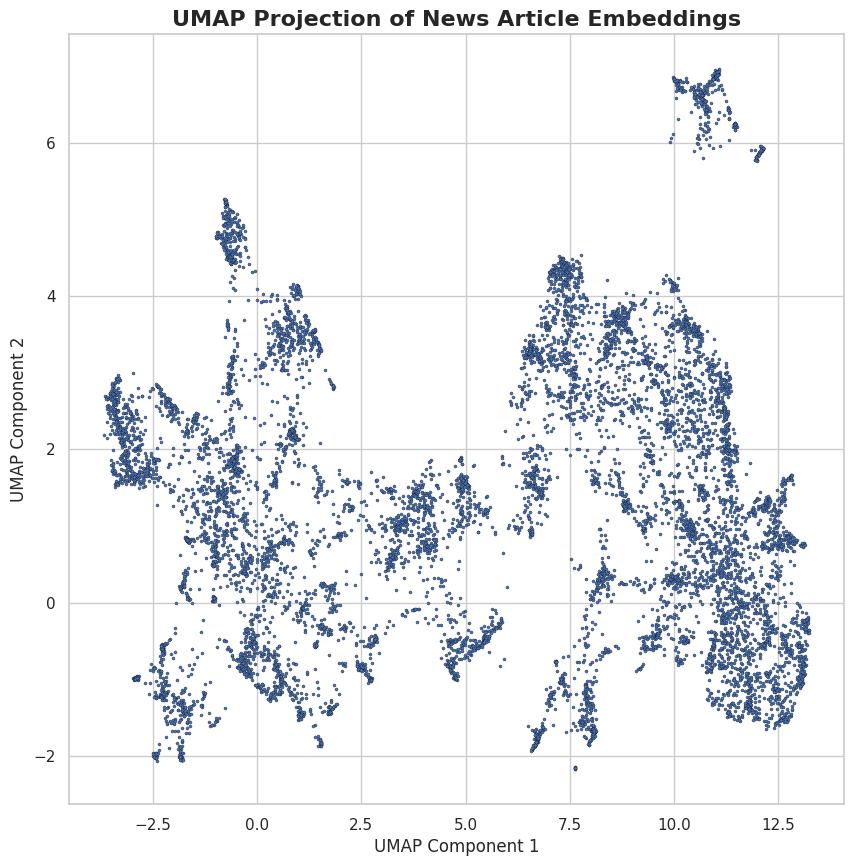

In [16]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.set(style="whitegrid")

scatter = sns.scatterplot(
    x=article_embeds_2D[:, 0], y=article_embeds_2D[:, 1], s=5, edgecolor="black", ax=ax
)

ax.set_title(
    "UMAP Projection of News Article Embeddings", fontsize=16, fontweight="bold"
)
ax.set_xlabel("UMAP Component 1", fontsize=12)
ax.set_ylabel("UMAP Component 2", fontsize=12)
ax.grid(True)

Each point in the above point represents an article.

## Questions

7.  Do we see distinct clusters?

Answer:

Not entirely. While the UMAP projection does show some areas where articles group more densely, the clusters are not sharply defined. There is noticeable overlap between article embeddings, suggesting that many articles share similar language or thematic elements. This lack of clear separation implies that while there may be latent topical structure in the data, it is not cleanly clustered in a way that would allow for easy, unsupervised topic identification without additional processing.


8.  Textual data is noisy; are the clusters as cleanly separated as in the toy example far above? Do we have enough information to answer this?

Answer:

No, the clusters in this case are not as clearly separated as those in the toy example. The toy dataset likely had well-labeled, simplified categories with more distinct feature boundaries. In contrast, real-world textual data—like news articles—tends to have overlapping themes, varied writing styles, and ambiguous language, which makes clean separation more difficult. Based on the UMAP visualization, we do have enough information to say that these clusters are messier and more blended than in the toy example, reflecting the natural complexity of text data.

### Clustering News Articles

We now apply a clustering algorithm to the embeddings to uncover distinct topics within the dataset. Similar to our earlier toy example, we expect that the resulting clusters will correspond to meaningful and coherent themes in the news cycle. By grouping similar embeddings together, we can analyze how economic discourse evolves over time and identify key narratives shaping financial markets and policy discussions.

Instead of using a simple partitioning method like k-Means, we employ Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN). While k-Means is widely used in clustering tasks, it assumes that all clusters have a spherical shape and that each data point must belong to a cluster. However, economic news data is often highly variable, context-dependent, and noisy, making k-Means less ideal for this application.

HDBSCAN is particularly well-suited for clustering text embeddings due to several key advantages:

1. Handles Varying Cluster Shapes and Sizes:
    Unlike k-Means, which assumes all clusters are roughly ball-shaped, HDBSCAN adapts to the natural distribution of the data. This is crucial for text data, where some topics may be densely discussed while others are more diffuse.

2. Identifies Outliers and Noise:
    Economic and financial news often contains a mix of structured reports, informal discussions, and less relevant content. HDBSCAN automatically classifies points as "noise" if they don’t fit well into any cluster, improving the quality of our topic groupings.

3. No Need to Predefine the Number of Clusters:
    Unlike k-Means, which requires specifying the number of clusters in advance, HDBSCAN determines the number of clusters dynamically based on data density. This makes it more robust when dealing with complex, high-dimensional datasets like financial news.

Applying any clustering algorithm on high-dimensional data is challenging due to the "Curse of Dimensionality". In high dimensions, data points tend to drift apart further, which makes it difficult to cluster them together meaningfully. Therefore, we use again the same dimension reduction technique, UMAP, to generate lower-dimensional embeddings that are easier to group together, but still contain the most important dependency structures from the original dataset. Instead of two dimensions, we now embed the data into five dimensions.  This dimension choice is standard practice which was arrived at by trial in many different machine learning papers. This seems to be a good trade-off between mitigating the "Curse of Dimensionality" and preserving information content.

In [17]:
umap_model_5D = umap.UMAP(n_components=5, random_state=42, metric="cosine")
article_embeds_5D = umap_model_5D.fit_transform(
    article_embeds
)  # Takes a few seconds...

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [18]:
article_embeds_5D = pd.DataFrame(article_embeds_5D, index=article_embeds.index)
article_embeds_5D

0         1          2         3  \
article_id                                                                     
dn_f8bdab034f25c52fd1b4bcb613595960  1.906715  2.484589   8.668094  5.038018   
dn_eda9a93b0ef50b1b69ccda5768160d95  9.253709  2.742160  10.817144  2.493172   
dn_8f1f54c084163e0236ccb02897402793  9.198256  3.788764   9.142410  4.795947   
dn_3c9e96385ceacaac43236038218e7249  3.682543  2.359953   8.984947  4.462906   
dn_e2cdd9e4346648abb6e51830948712fb  1.399747  2.759066   8.715836  4.787305   
...                                       ...       ...        ...       ...   
dn_e3ad31a908b3bfc86a766e20610c6d45  9.715367  3.169063   8.561137  3.193437   
dn_32794cd2fb89e5e488afbed511eb5f46  8.508044  3.703140   8.622041  4.998183   
dn_cc433ecbd320f55c658834ae6b4742d0  5.829710  1.831139   7.936148  3.706509   
dn_0701d085a3dda7bd2593463d0444ebb7  0.723516  2.542945   8.108651  6.814050   
dn_77715f48eb6379cd26e2f006d3705bcf  9.402420  3.332560  11.201641  2.750106   

                                            4  
article_id                                     
dn_f8bdab034f25c52fd1b4bcb613595960  4.096303  
dn_eda9a93b0ef50b1b69ccda5768160d95  4.945054  
dn_8f1f54c084163e0236ccb02897402793  5.991445  
dn_3c9e96385ceacaac43236038218e7249  4.242599  
dn_e2cdd9e4346648abb6e51830948712fb  6.644386  
...                                       ...  
dn_e3ad31a908b3bfc86a766e20610c6d45  5.005560  
dn_32794cd2fb89e5e488afbed511eb5f46  5.935801  
dn_cc433ecbd320f55c658834ae6b4742d0  3.941456  
dn_0701d085a3dda7bd2593463d0444ebb7  5.832576  
dn_77715f48eb6379cd26e2f006d3705bcf  4.998669  

[10000 rows x 5 columns]

We have now managed to compress the original embeddings into a five-dimensional representation, down from 768 dimensions. We have also made sure it is a correctly formatted data frame (called pd.DataFrame). Next, we apply the HDBSCAN algorithm for clustering:

In [19]:
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=200,  # Require at least 2000 points per cluster (forces larger clusters)
    min_samples=5,  # Higher values reduce noise points, leading to larger clusters
    metric="euclidean",
    cluster_selection_method="eom",  # This promotes fewer, larger clusters
)

labels = hdbscan_model.fit_predict(article_embeds_5D)
labels = pd.Series(labels, index=article_embeds_5D.index)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


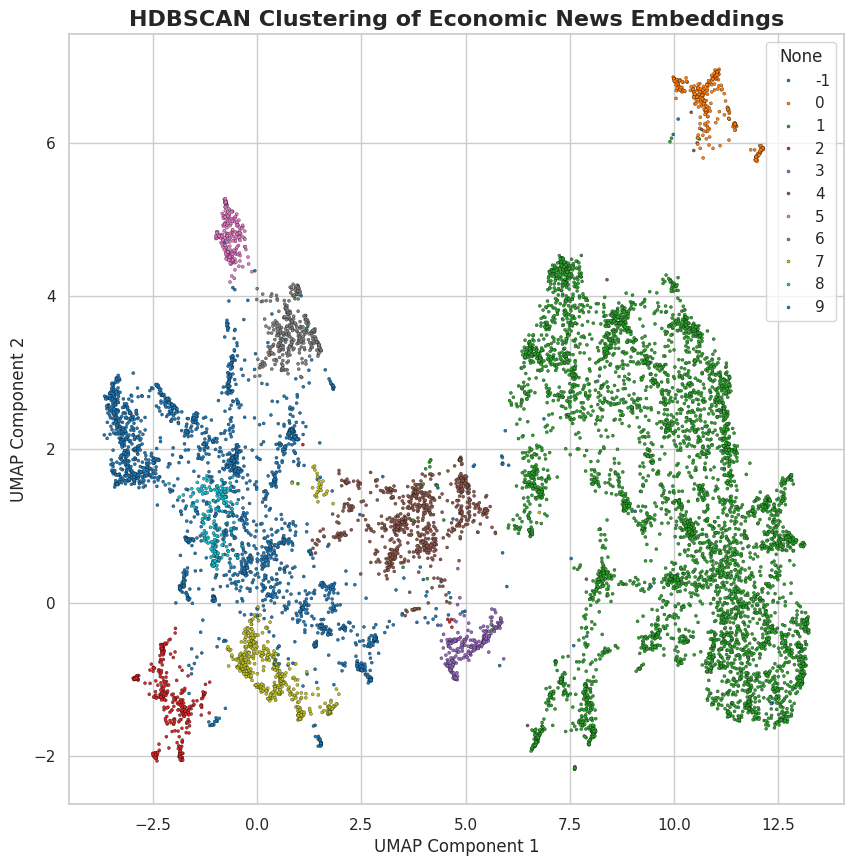

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.set(style="whitegrid")

scatter = sns.scatterplot(
    x=article_embeds_2D[:, 0],
    y=article_embeds_2D[:, 1],
    hue=labels,
    palette="tab10",
    s=5,
    edgecolor="black",
    ax=ax,
)

ax.set_title(
    "HDBSCAN Clustering of Economic News Embeddings", fontsize=16, fontweight="bold"
)
ax.set_xlabel("UMAP Component 1", fontsize=12)
ax.set_ylabel("UMAP Component 2", fontsize=12)
ax.grid(True)

We manage to identify 11 distinct clusters. In the 2D visualization, some clusters are overlapping. This is most likely due to limitations of the two dimensional representation, which does not contain enough information to adequately represent the clusters. We therefore visualize our clustering in three dimensions, hoping that the additional dimension will be enough to cleanly separate the clusters.

In [21]:
umap_model_3D = umap.UMAP(
    n_components=3,  # Reduce to 3D for interactive visualization
    metric="cosine",
    random_state=42,
)
article_embeds_3D = umap_model_3D.fit_transform(
    article_embeds
)  # Takes a few seconds...

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [22]:
import nbformat

color_palette = px.colors.qualitative.Plotly

mask = labels != -1  # Boolean mask to exclude noise points

filtered_embeds = article_embeds_3D[mask]
filtered_labels = labels[mask]
num_clusters = len(set(filtered_labels))
color_scale = color_palette * (num_clusters // len(color_palette) + 1)

filtered_labels_str = [str(label) for label in filtered_labels]

fig = px.scatter_3d(
    x=filtered_embeds[:, 0],
    y=filtered_embeds[:, 1],
    z=filtered_embeds[:, 2],
    color=filtered_labels_str,
    title="HDBSCAN Clustering of Economic News Embeddings",
    labels={"x": "UMAP Dim 1", "y": "UMAP Dim 2", "z": "UMAP Dim 3"},
    opacity=1,  # Reduce opacity slightly
    color_discrete_sequence=color_scale[:num_clusters],
)

fig.update_layout(autosize=False, width=1200, height=800)

fig.update_traces(marker=dict(size=2))
fig.show()

The 3D representation manages to more cleanly separate the clusters. We next try to label the clusters by examing the most salient key words within each grouping.

In [23]:
def cluster_visual_analysis(cluster_articles):
    stopwords = set(wordcloud.STOPWORDS).union(set(["WSJ", "DJ", "UPDATE", "said"]))

    combined_text = ""
    if len(cluster_articles) > 5000:
        subsample = np.random.choice(
            np.arange(len(cluster_articles)), 5000, replace=False
        )
    else:
        subsample = np.arange(len(cluster_articles))

    for i in tqdm.tqdm(range(len(subsample))):
        combined_text += " " + cluster_articles["headline"].iloc[subsample[i]]
        combined_text += " " + cluster_articles["body"].iloc[subsample[i]]

    wordcloud_text = wordcloud.WordCloud(
        stopwords=stopwords, background_color="white"
    ).generate(combined_text)

    return wordcloud_text

100%|██████████| 317/317 [00:00<00:00, 38035.14it/s]


Text(0.5, 1.0, 'Cluster 0: FX markets')

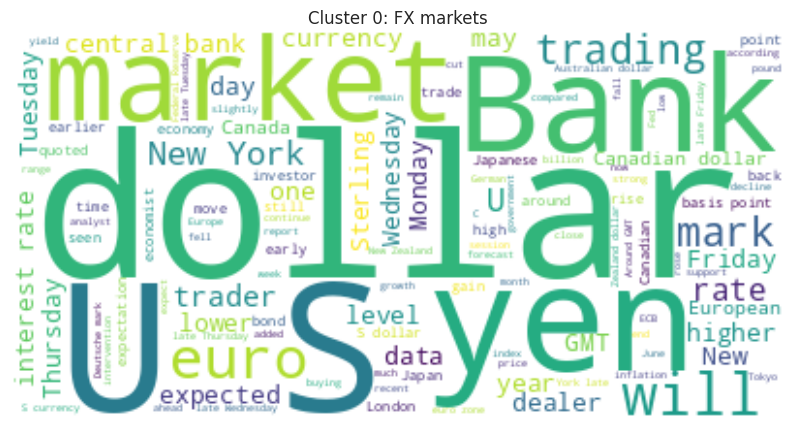

In [24]:
cluster = 0
cluster_0 = articles.loc[labels[labels == cluster].index]
wordcloud_0 = cluster_visual_analysis(cluster_0)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_0, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 0: FX markets")

100%|██████████| 5000/5000 [00:00<00:00, 53707.99it/s]


Text(0.5, 1.0, 'Cluster 1: US stocks/companies')

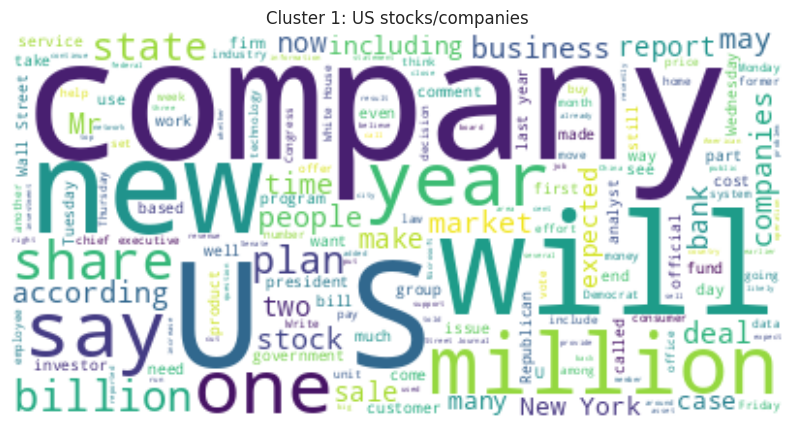

In [25]:
cluster = 1
cluster_1 = articles.loc[labels[labels == cluster].index]
wordcloud_1 = cluster_visual_analysis(cluster_1)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_1, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 1: US stocks/companies")

100%|██████████| 372/372 [00:00<00:00, 43907.05it/s]


Text(0.5, 1.0, 'Cluster 2: Government/Politics')

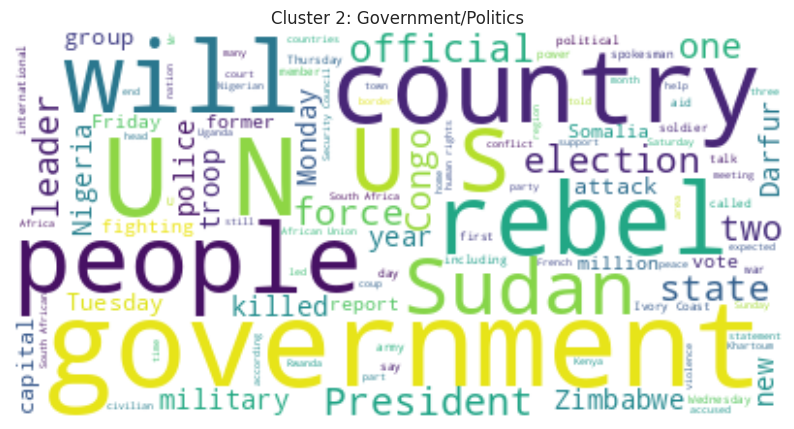

In [26]:
cluster = 2
cluster_2 = articles.loc[labels[labels == cluster].index]
wordcloud_2 = cluster_visual_analysis(cluster_2)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 2: Government/Politics")

100%|██████████| 239/239 [00:00<00:00, 24140.61it/s]


Text(0.5, 1.0, 'Cluster 3: Pandemics')

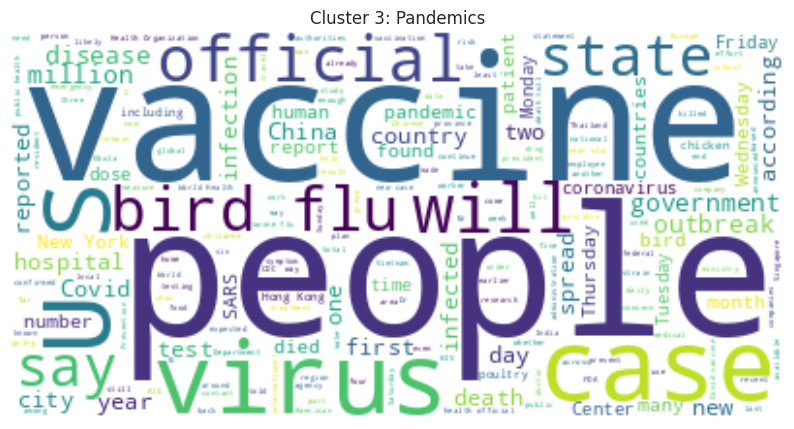

In [27]:
cluster = 3
cluster_3 = articles.loc[labels[labels == cluster].index]
wordcloud_3 = cluster_visual_analysis(cluster_3)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_3, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 3: Pandemics")

100%|██████████| 704/704 [00:00<00:00, 44664.80it/s]


Text(0.5, 1.0, 'Cluster 4: International Trade')

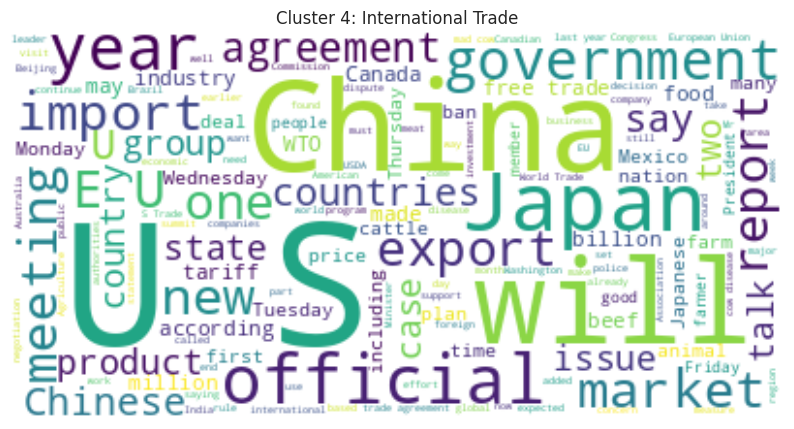

In [28]:
cluster = 4
cluster_4 = articles.loc[labels[labels == cluster].index]
wordcloud_4 = cluster_visual_analysis(cluster_4)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_4, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 4: International Trade")

100%|██████████| 222/222 [00:00<00:00, 39968.04it/s]


Text(0.5, 1.0, 'Cluster 5: Central Europe conflicts')

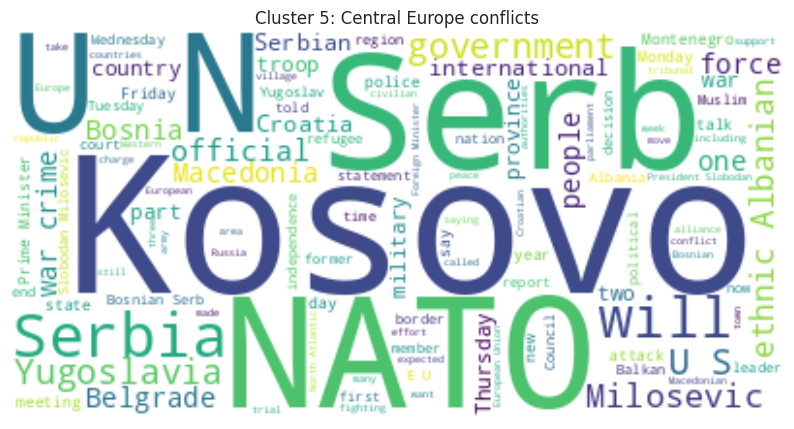

In [29]:
cluster = 5
cluster_5 = articles.loc[labels[labels == cluster].index]
wordcloud_5 = cluster_visual_analysis(cluster_5)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_5, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 5: Central Europe conflicts")

100%|██████████| 338/338 [00:00<00:00, 41709.81it/s]


Text(0.5, 1.0, 'Cluster 6: Eastern Europe conflict')

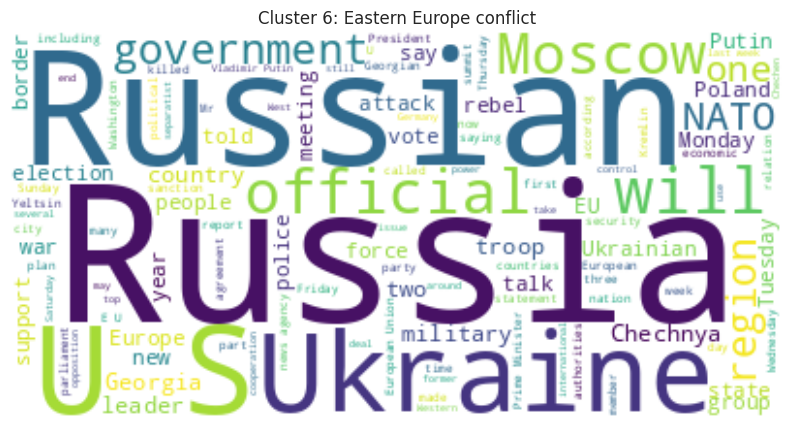

In [30]:
cluster = 6
cluster_6 = articles.loc[labels[labels == cluster].index]
wordcloud_6 = cluster_visual_analysis(cluster_6)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_6, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 6: Eastern Europe conflict")

100%|██████████| 456/456 [00:00<00:00, 40717.06it/s]


Text(0.5, 1.0, 'Cluster 7: Afghanistan/Pakistan/Terrorism')

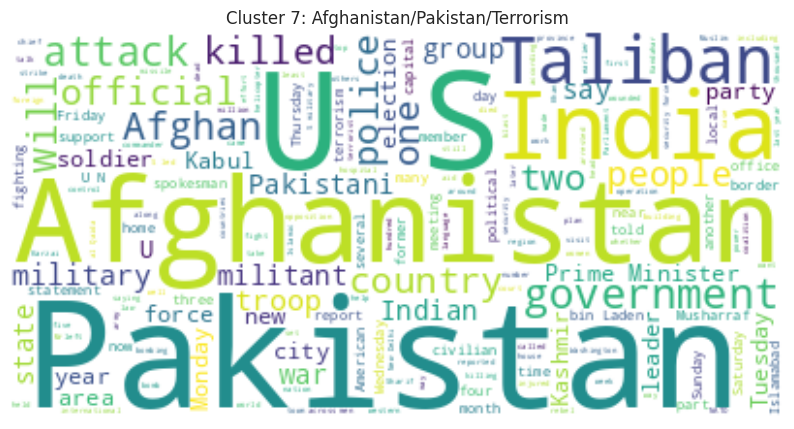

In [31]:
cluster = 7
cluster_7 = articles.loc[labels[labels == cluster].index]
wordcloud_7 = cluster_visual_analysis(cluster_7)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_7, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 7: Afghanistan/Pakistan/Terrorism")

100%|██████████| 202/202 [00:00<00:00, 44252.03it/s]


Text(0.5, 1.0, 'Cluster 8: Middle East conflicts')

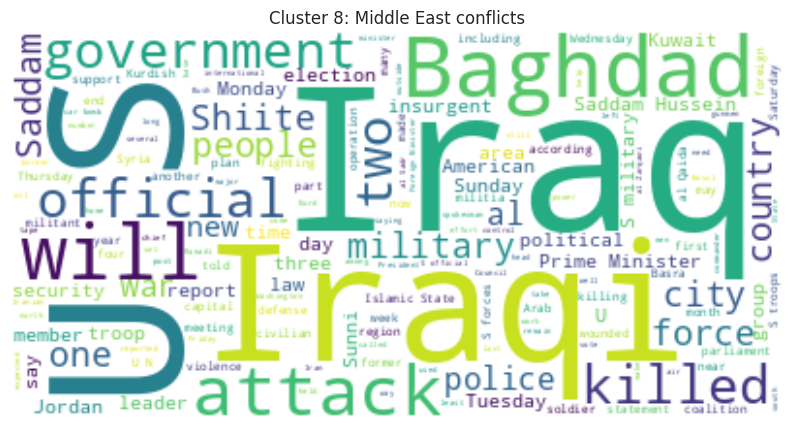

In [32]:
cluster = 8
cluster_8 = articles.loc[labels[labels == cluster].index]
wordcloud_8 = cluster_visual_analysis(cluster_8)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_8, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 8: Middle East conflicts")

100%|██████████| 449/449 [00:00<00:00, 33778.32it/s]


Text(0.5, 1.0, 'Cluster 9: Israel/Palestine')

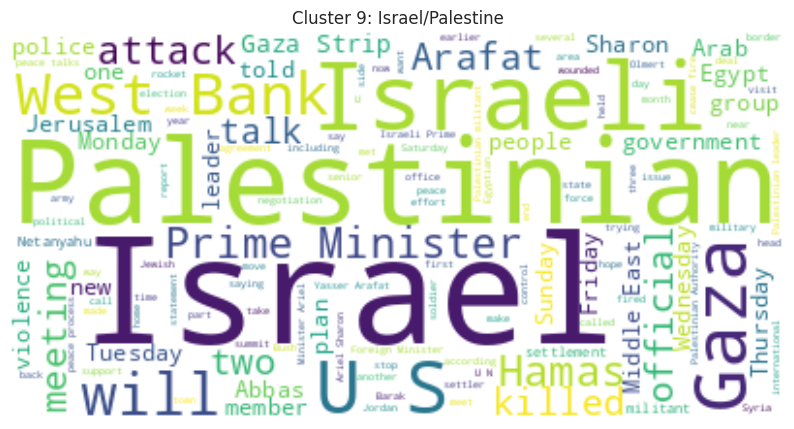

In [33]:
cluster = 9
cluster_9 = articles.loc[labels[labels == cluster].index]
wordcloud_9 = cluster_visual_analysis(cluster_9)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_9, interpolation="bilinear")
plt.axis("off")
plt.title(r"Cluster 9: Israel/Palestine")

## Question

9.  Do the derived clusters, as interpreted with the word clouds, show any patterns?

Answer:

Yes, the derived clusters exhibit clear and interpretable patterns, as shown by the word clouds. Each cluster groups together articles with common themes, making the topics easily identifiable through the most frequent terms.

For example:

* **Cluster 0** focuses on **foreign exchange markets**, with dominant words like “dollar,” “yen,” “bank,” “FX,” and “trader.”
* **Cluster 1** centers on **U.S. companies and stocks**, featuring terms such as “company,” “share,” “million,” and “business.”
* **Cluster 2** is about **government and political issues**, with frequent mentions of “government,” “country,” “UN,” and “people.”
* **Cluster 3** is clearly about **pandemics**, as indicated by words like “vaccine,” “virus,” “flu,” “Covid,” and “infection.”
* **Cluster 4** relates to **international trade**, with keywords like “China,” “Japan,” “export,” “import,” and “agreement.”
* **Clusters 5 through 9** capture **regional conflicts**, with each cluster representing a different geographical area:

  * Cluster 5: **Central Europe** (e.g., “Kosovo,” “Serbia,” “NATO”)
  * Cluster 6: **Eastern Europe** (e.g., “Russia,” “Ukraine,” “Moscow”)
  * Cluster 7: **Afghanistan and terrorism-related content** (e.g., “Afghanistan,” “Pakistan,” “Taliban”)
  * Cluster 8: **Middle East conflicts** (e.g., “Iraq,” “Baghdad,” “Saddam”)
  * Cluster 9: **Israel–Palestine conflict** (e.g., “Israel,” “Palestinian,” “Gaza”)

Overall, the clusters are well-separated and reflect meaningful topics within the economic and geopolitical news landscape, demonstrating that the model was successful in grouping articles by coherent themes.


## Topic relevance within new cycles

Topic relevance, derived from clustering high-dimensional text embeddings, represents the relative importance and prominence of different themes within a given dataset. By applying our LLM of choice, we identified distinct topic clusters that emerge naturally from the data. Each cluster groups together articles that share similar contextual meanings, effectively mapping them into well-defined topical structures.

Since our dataset contains also publication dates, we can also analyze our topics dynamically. Larger clusters tend to indicate dominant themes. When analyzing news articles over time, tracking changes in cluster prominence provides insights into shifting economic narratives and market sentiment evolution. We define attention towards a given topic $k$ in month $t$ as the fraction of articles $a_t$ in month $t$ devoted to that topic. High attention values imply that a topic is currently dominating the news cycle.

In the context of economic NLP applications, topic attention can help:
- Identify dominant discourse trends in financial news, policymaker statements, and market analysis reports.
- Detect emerging concerns (e.g., early indicators of a financial crisis based on shifting topic weights).
- Enhance predictive models by integrating topic evolution into market sentiment forecasting.

Such measures allow researchers to quantitatively track the thematic focus in economic text data at scale. We illustrate this for two topics in our clustering.  

The following python scripts plot the fraction of articles belonging to each cluster.



In [34]:
articles_with_labels = pd.concat([articles, labels], axis=1)
articles_with_labels.columns = list(articles.columns) + ["cluster"]
articles_with_labels["count"] = [1 for i in range(len(articles_with_labels))]
articles_with_labels["display_month"] = [
    dd.strftime("%Y-%m") for dd in articles_with_labels["display_date"]
]
articles_with_labels = articles_with_labels.drop("display_date", axis=1)

# The next code defines "attention" - careful, this is the English notion of attention as in attention of news media to topics -- not attention like in transformer neural network architectures
attention_index_month_pre = articles_with_labels.groupby(
    ["display_month", "cluster"]
).sum()
total_counts_month = attention_index_month_pre.groupby("display_month").sum()
total_counts_month = total_counts_month.reset_index()
attention_index_month_pre = attention_index_month_pre.reset_index("cluster")
attention_index_month = pd.merge(
    attention_index_month_pre, total_counts_month, on="display_month"
)
attention_index_month["attention"] = (
    attention_index_month["count_x"] / attention_index_month["count_y"]
)
attention_index_month = attention_index_month.drop(["count_x", "count_y"], axis=1)
attention_month = attention_index_month.pivot(
    index="display_month", columns="cluster", values="attention"
)
attention_month = attention_month.sort_index()
attention_month = attention_month.fillna(0)
attention_month.index = pd.DatetimeIndex(attention_month.index)
attention_month.index = pd.to_datetime(
    attention_month.index.values
) + pd.offsets.MonthEnd(0)
attention_month = attention_month.loc[
    "1995":
]  # Starting in 1995 due to better article coverage

Text(0, 0.5, 'Relevance')

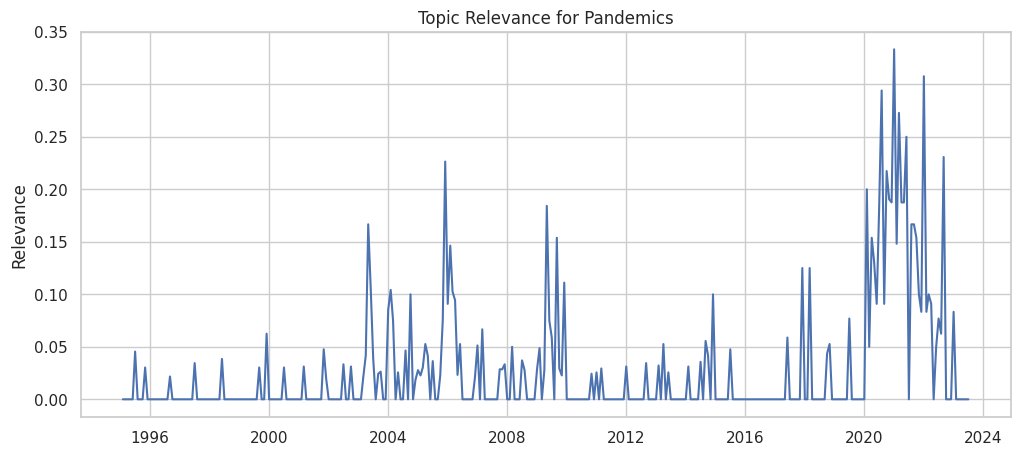

In [35]:
plt.figure(figsize=(12, 5))
plt.plot(attention_month.loc[:, 3])
plt.title(r"Topic Relevance for Pandemics")
plt.ylabel("Relevance")

Text(0, 0.5, 'Relevance')

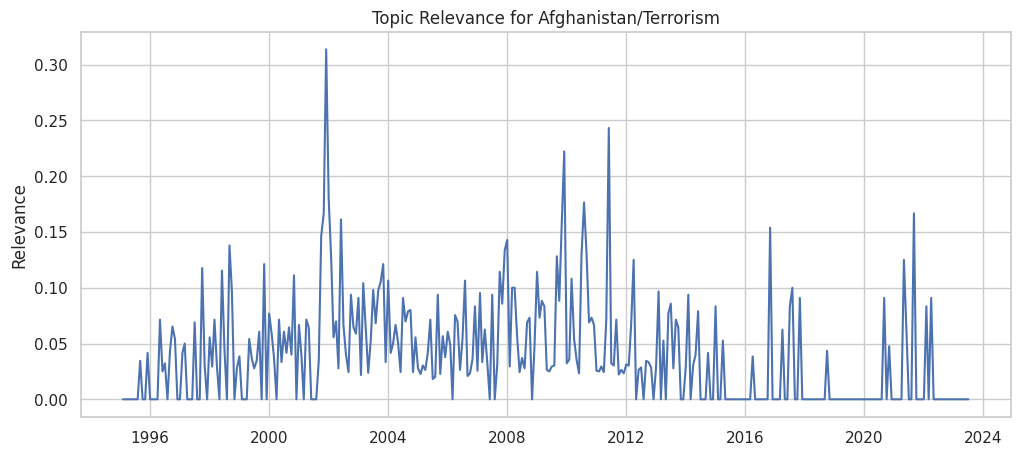

In [36]:
plt.figure(figsize=(12, 5))
plt.plot(attention_month.loc[:, 7])
plt.title(r"Topic Relevance for Afghanistan/Terrorism")
plt.ylabel("Relevance")

## Question

10.  Can you relate spikes in these attention indices to real-life events?

Answer:

Yes, the spikes in attention indices align closely with major historical events:

Pandemics cluster (Cluster 3): Notable spikes appear in 2003 (SARS outbreak), 2009 (H1N1 flu pandemic), and especially from late 2019 through 2021, corresponding to the COVID-19. These peaks reflect heightened media attention during public health crises.

Terrorism cluster (Cluster 7): Significant spikes occur in late 2001, shortly after the September 11 attacks and the beginning of the US invasion of Afghanistan. Another cluster of spikes appears around 2010–2012, coinciding with heightened conflict, troop surges, and the killing of Osama bin Laden in 2011. The frequency tapers off in recent years, likely reflecting reduced Western military presence and media focus.